In [ ]:
# prerequisite: 
# run draw3aHists.ipynb, drawPadVetoedHists.ipynb and drawProtonHists.ipynb 
# with output "res_alpha_corrected.dat", "res_padVetoed_corrected.dat" and "res_proton_corrected.dat"
# more todo

In [5]:
import os
#exec(open(os.path.expanduser('~') + "/matplotlibpreamble.py").read())
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak

In [28]:
raw = np.array([])
for batch in uproot.iterate(("../../data/unpacked/Si/098_*.root:h101",
                             "../../data/unpacked/Si/099_*.root:h101",
                             "../../data/unpacked/Si/100_*.root:h101",
                             "../../data/unpacked/Si/101_*.root:h101"), expressions=["U6F_E"], cut="U6FI == 8"):
    raw = np.append(raw, ak.flatten(batch.U6F_E))

In [29]:
base = "U6F8"
with uproot.open("../../data/cal/3aha_before.root") as file:
    # data
    y1a, x1a = file[base].to_numpy()
    x0a = np.min(x1a)
    x1a = x1a[:-1] + 0.5
    # tspectrum
    y2a, x2a = file[base + "A"].to_numpy()
    x2a = x2a[:-1] + 0.5 + x0a
    # peak positions, in found order
    x3a, y3a = file[base + "P"].values()
    x3a = x3a + x0a
with uproot.open("../../data/cal/pvha.root") as file:
    # data
    y1p, x1p = file[base].to_numpy()
    x0p = np.min(x1p)
    x1p = x1p[:-1] + 0.5
    # tspectrum
    y2p, x2p = file[base + "A"].to_numpy()
    x2p = x2p[:-1] + 0.5 + x0p
    # peak positions, in found order
    x3p, y3p = file[base + "P"].values()
    x3p = x3p + x0p

from scipy.optimize import curve_fit
def lin(x, a, b):
    return a*x + b

/tmp/ipykernel_12459/3284523209.py:136: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if not ax.is_last_row():


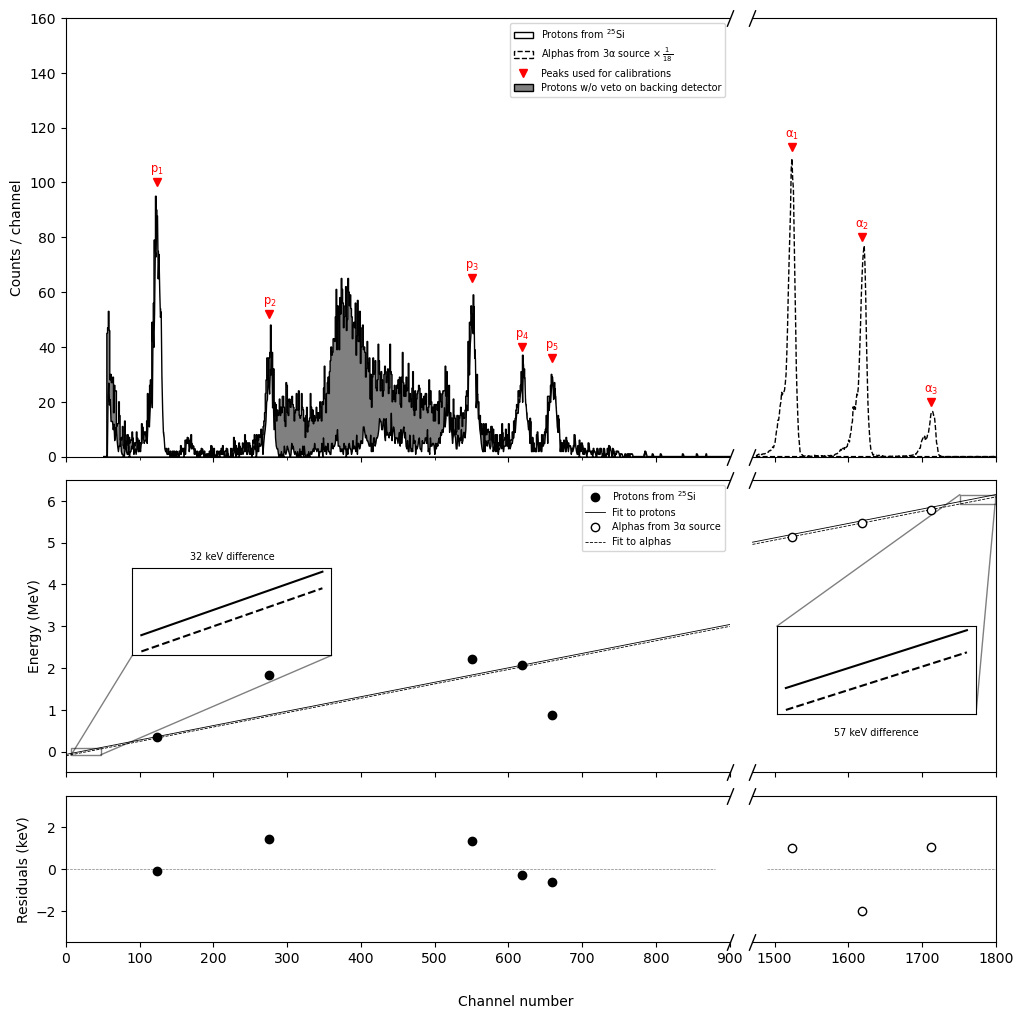

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# --- Definitions from your script ---
xl1 = 0
xu1 = 900
xl2 = 1470
xu2 = 1800

XP = np.linspace(xl1, xu1, 100)
XA = np.linspace(xl2, xu2, 100)
a_prot = 3.456223218586921
b_prot = -69.7727316735724
a_alph = 3.4421955727506153
b_alph = -101.90057879240454

def lin(x, a, b):
    return a*x + b
def lin_err(x, aerr, berr, aberr):
    return np.sqrt(aerr*x**2* + berr + x*aberr)

# The following variables are assumed to be defined elsewhere in your code:
# raw, x1p, y1p, x3p, x1a, y1a, x3a

# --- Create a single figure with a 3x2 grid and custom ratios ---
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    sharey='row', # Share y-axis for each row
    figsize=(12, 12),
    gridspec_kw={
        'hspace': 0.08,
        'wspace': 0.05,
        'height_ratios': [3, 2, 1],
        'width_ratios': [xu1 - xl1, xu2 - xl2]
    }
)

# --- LEFT COLUMN PLOTS ---

# Subplot: axes[0, 0]
ax = axes[0, 0]
ax.hist(raw, bins=np.arange(np.min(x1p), np.max(x1p), (np.max(x1p) - np.min(x1p))/len(x1p)),
        histtype='stepfilled', color='grey', edgecolor='k', label='Protons w/o veto on backing detector')
ax.fill_between(x1p, 0, y1p, edgecolor='k', facecolor='w', label='Protons from $^{25}\mathrm{Si}$')
ax.fill_between([-100, -99], 0, -100, edgecolor='k', facecolor='w', linestyle='--',
                label='Alphas from 3α source $\\times\,\\frac{1}{18}$')
ax.set_xticks(np.arange(0, 801, 200))
ax.set_xticks(np.arange(0, 801, 100), minor=True)
ax.set_ylim(0, 160)
ax.set_ylabel("Counts / channel")

y3p = [100, 52, 65, 40, 36]
ax.plot(np.sort(x3p[0:5]), y3p, c='r', ls='', marker='v', label='Peaks used for calibrations')
subs = ["1", "2", "3", "4", "5"]
for x, y, sub in zip(np.sort(x3p[0:5]), y3p, subs):
    ax.text(x, y+2, "$\mathrm{p_{%s}}$" % sub, va='bottom', ha='center', c='r', size='small')

handles, labels = ax.get_legend_handles_labels()
order = [1, 2, 3, 0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize='x-small')

# Subplot: axes[1, 0]
ax = axes[1, 0]
ax.plot(np.sort(x3p[0:5]), lin(x3p[0:5], a_prot, b_prot)/1e3, 'ko', label='Protons from $^{25}\mathrm{Si}$')
ax.plot(XP, lin(XP, a_prot, b_prot)/1e3, 'k-', lw=0.6, label='Fit to protons')
ax.plot(-50, -50, 'ko', markerfacecolor='w', label='Alphas from 3α source')
ax.plot(XP, lin(XP, a_alph, b_alph)/1e3, 'k--', lw=0.6, label='Fit to alphas')
ax.set_ylim(-0.5, 6.5)
ax.set_ylabel("Energy (MeV)")
ax.legend(fontsize='x-small')

axin = ax.inset_axes([0.1, 0.4, 0.30, 0.30])
f1 = (0 < XP) & (XP < 50)
axin.plot(XP[f1], lin(XP[f1], a_prot, b_prot)/1e3, 'k-')
axin.plot(XP[f1], lin(XP[f1], a_alph, b_alph)/1e3, 'k--')
axin.set_xticks([])
axin.set_yticks([])
ax.indicate_inset_zoom(axin, edgecolor="black")
axin.set_title(f"{int(abs(b_alph-b_prot))} keV difference", fontsize='x-small')

# Subplot: axes[2, 0]
ax = axes[2, 0]
ax.plot([xl1, xu1 - 20], [0, 0], ls='--', c='grey', lw=0.5)
ax.plot(np.sort(x3p[0:5]), [-0.10036446,  1.45314796,  1.3192754,  -0.29206019, -0.61011976], 'ko')
ax.set_ylim(-3.5, 3.5)
ax.set_ylabel("Residuals (keV)")

# --- RIGHT COLUMN PLOTS ---

# Subplot: axes[0, 1]
ax = axes[0, 1]
ax.fill_between(x1a[x1a > xl2 + 5], 0, y1a[x1a > xl2 + 5]/18, edgecolor='k', facecolor='w', linestyle='--')
#ax.set_xticks(np.arange(1800, 1801, 200))
ax.set_xticks(np.arange(1500, 1801, 100), minor=True)
ax.set_ylim(0, 160) # Correction 3: Explicitly set ylim to match left side

y3a = [113, 80, 20]
ax.plot(x3a, y3a, c='r', ls='', marker='v')
subs = ["1", "2", "3"]
for x, y, sub in zip(x3a, y3a, subs):
    ax.text(x, y+2, "$\mathrm{\\alpha_{%s}}$" % sub, va='bottom', ha='center', c='r', size='small')

# Subplot: axes[1, 1]
ax = axes[1, 1]
ax.plot(XA, lin(XA, a_prot, b_prot)/1e3, 'k-', lw=0.6)
ax.plot(XA, lin(XA, a_alph, b_alph)/1e3, 'k--', lw=0.6)
ax.plot(x3a[0:3], lin(x3a[0:3], a_alph, b_alph)/1e3, 'ko', markerfacecolor='w', zorder=10)
ax.set_ylim(-0.5, 6.5) # Correction 3: Explicitly set ylim to match left side

axin = ax.inset_axes([0.1, 0.2, 0.30/((xu2 - xl2)/(xu1 - xl1)), 0.30])
f2 = (1750 < XA) & (XA < 1800)
axin.plot(XA[f2], lin(XA[f2], a_prot, b_prot)/1e3, 'k-')
axin.plot(XA[f2], lin(XA[f2], a_alph, b_alph)/1e3, 'k--')
axin.set_xticks([])
axin.set_yticks([])
ax.indicate_inset_zoom(axin, edgecolor="black")
axin.set_title(f"{int(abs(lin(xu2,a_prot,b_prot)-lin(xu2,a_alph,b_alph)))} keV difference", y=-0.34, fontsize='x-small')

# Subplot: axes[2, 1]
ax = axes[2, 1]
ax.plot([20 + xl2, xu2], [0, 0], ls='--', c='grey', lw=0.5)
ax.plot(x3a[0:3], [ 0.98454137, -2.02258407,  1.03804269], 'ko', markerfacecolor='w')
ax.set_ylim(-3.5, 3.5) # Correction 3: Explicitly set ylim to match left side

# --- BROKEN AXIS VISUALS AND FINAL TOUCHES ---

# Set the x-limits for each column
for ax in axes[:, 0]:
    ax.set_xlim(xl1, xu1)
for ax in axes[:, 1]:
    ax.set_xlim(xl2, xu2)

# Hide the labels for axes that are not on the edge
for ax in axes.flat:
    if not ax.is_last_row():
        ax.tick_params(labelbottom=False)

# Hide the adjoining spines and ticks
for ax in axes[:, 0]:
    ax.spines['right'].set_visible(False)
for ax in axes[:, 1]:
    ax.spines['left'].set_visible(False)
    # Correction 1: Hide tick marks (not just labels) on the left of the right-hand plots
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)

# Correction 2: Add the diagonal "break" marks to all rows
d = 2.5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
for i in range(3):
    axes[i, 0].plot([1, 1], [0, 1], transform=axes[i, 0].transAxes, **kwargs)
    axes[i, 1].plot([0, 0], [0, 1], transform=axes[i, 1].transAxes, **kwargs)

# Add a single, centered x-axis label
fig.text(0.5, 0.06, 'Channel number', rotation='horizontal', ha='center', va='center')

plt.savefig("U6F8siacomp.pdf", bbox_inches='tight')
plt.show()

In [52]:
E0s = np.array([385.72, 904.02, 1843.2, 2076.7, 2217.4])
Es = np.loadtxt('U1-6EE.dat').flatten()

E0sa = np.array([5155.4, 5485.74, 5804.96])
Esa = np.array([])
Esa = np.append(Esa, np.loadtxt('U1U2a.dat').flatten())
Esa = np.append(Esa, np.loadtxt('U3U4a.dat').flatten())
Esa = np.append(Esa, np.loadtxt('U5a.dat').flatten())
Esa = np.append(Esa, np.loadtxt('U6a.dat').flatten())

112
168


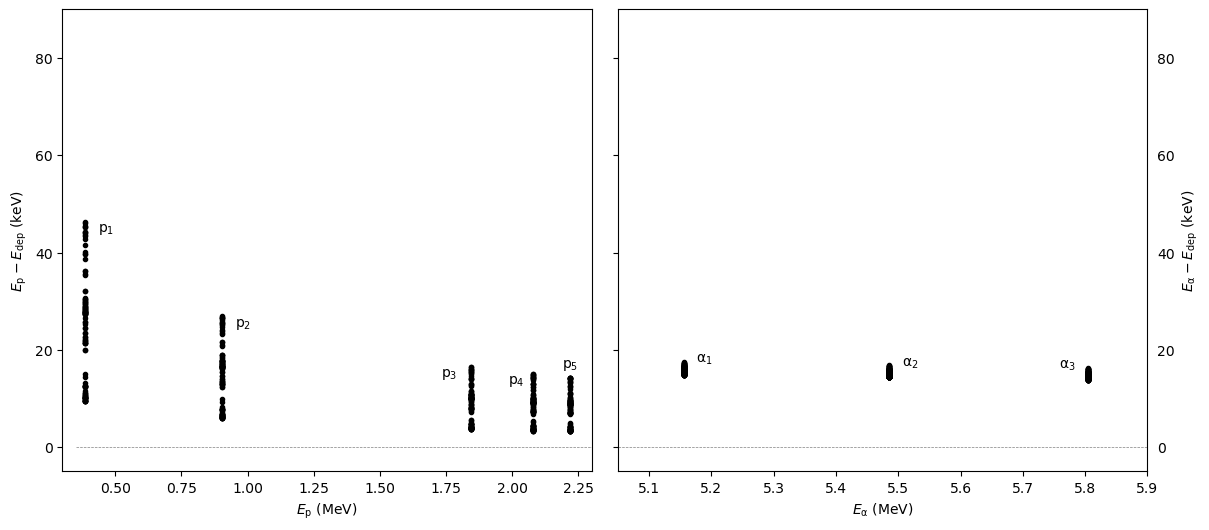

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# The following data arrays from your script are assumed to be defined elsewhere:
# Es, E0s, Esa, E0sa

# --- Create a single figure with a 1x2 grid of subplots ---
# This standard command replaces the custom 'prepare_two_column_figure' function.
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    sharey=True,
    figsize=(14, 6), # A reasonable size for a side-by-side layout
    gridspec_kw={'wspace': 0.05}
)

# --- Populate the Left Plot (axes[0]) ---
N = int(len(Es) / 5)
print(N)

ax = axes[0]
ax.plot(E0s[0] * np.ones(N) / 1e3, E0s[0] * np.ones(N) - Es[0::5], 'k.')
ax.plot(E0s[1] * np.ones(N) / 1e3, E0s[1] * np.ones(N) - Es[1::5], 'k.')
ax.plot(E0s[2] * np.ones(N) / 1e3, E0s[2] * np.ones(N) - Es[2::5], 'k.')
ax.plot(E0s[3] * np.ones(N) / 1e3, E0s[3] * np.ones(N) - Es[3::5], 'k.')
ax.plot(E0s[4] * np.ones(N) / 1e3, E0s[4] * np.ones(N) - Es[4::5], 'k.')

ax.text(0.05 + E0s[0] / 1e3, np.max(E0s[0] * np.ones(N) - Es[0::5]), "$\mathrm{p}_1$", ha="left", va="top")
ax.text(0.05 + E0s[1] / 1e3, np.max(E0s[1] * np.ones(N) - Es[1::5]), "$\mathrm{p}_2$", ha="left", va="top")
ax.text(E0s[2] / 1e3 - 0.05, np.max(E0s[2] * np.ones(N) - Es[2::5]), "$\mathrm{p}_3$", ha="right", va="top")
ax.text(E0s[3] / 1e3 - 0.03, np.max(E0s[3] * np.ones(N) - Es[3::5]), "$\mathrm{p}_4$", ha="right", va="top")
ax.text(E0s[4] / 1e3, np.max(E0s[4] * np.ones(N) - Es[4::5]) + 1, "$\mathrm{p}_5$", ha="center", va="bottom")

ax.set_xlabel("$E_{\mathrm{p}}$ (MeV)")
ax.set_ylabel("$E_{\mathrm{p}} - E_{\mathrm{dep}}$ (keV)")
ax.set_xlim(0.300, 2.300)
ax.set_ylim(-5, 90)
ax.plot([.350, 2.300], [0, 0], ls='--', c='grey', lw=0.5)

# --- Populate the Right Plot (axes[1]) ---
M = int(len(Esa) / 3)
print(M)

ax = axes[1]
ax.plot(E0sa[0] * np.ones(M) / 1e3, E0sa[0] * np.ones(M) - Esa[0::3], 'k.')
ax.text(0.02 + E0sa[0] / 1e3, 2 + np.max(E0sa[0] * np.ones(M) - Esa[0::3]), "$\mathrm{\\alpha}_1$", ha="left", va="top")
ax.plot(E0sa[1] * np.ones(M) / 1e3, E0sa[1] * np.ones(M) - Esa[1::3], 'k.')
ax.text(0.02 + E0sa[1] / 1e3, 2 + np.max(E0sa[1] * np.ones(M) - Esa[1::3]), "$\mathrm{\\alpha}_2$", ha="left", va="top")
ax.plot(E0sa[2] * np.ones(M) / 1e3, E0sa[2] * np.ones(M) - Esa[2::3], 'k.')
ax.text(E0sa[2] / 1e3 - 0.02, 2 + np.max(E0sa[2] * np.ones(M) - Esa[2::3]), "$\mathrm{\\alpha}_3$", ha="right", va="top")

ax.set_xlabel("$E_{\mathrm{\\alpha}}$ (MeV)")
ax.set_ylabel("$E_{\mathrm{\\alpha}} - E_{\mathrm{dep}}$ (keV)")
ax.tick_params(labelleft=False, labelright=True) # Move ticks to the right
ax.yaxis.set_label_position("right") # Move label to the right
ax.set_xlim(5.05, 5.9)
ax.plot([5.05, 5.9], [0, 0], ls='--', c='grey', lw=0.5)

# --- Save and show the final figure ---
plt.savefig("cal-eloss.pdf", bbox_inches="tight")
plt.show()

In [77]:
resp0 = np.loadtxt("res_padVetoed_uncorrected.dat")
resp = np.loadtxt("res_padVetoed_corrected.dat")
resa = np.loadtxt("res_alpha_corrected_before.dat")
resP0_U4 = np.loadtxt("res_U4_uncorrected.dat")
resP_U4 = np.loadtxt("res_U4_corrected.dat")
resP0_U5 = np.loadtxt("res_U5_uncorrected.dat")
resP_U5 = np.loadtxt("res_U5_corrected.dat")
resP0 = np.concatenate((resP0_U4, resP0_U5))
resP = np.concatenate((resP_U4, resP_U5))

In [78]:
#print(len(resp0)/5, len(resp)/5, len(resa)/3, len(resP0_U4)/4, len(resP_U4)/4)

In [79]:
print(np.min(resp0), np.max(resp0))
print(np.min(resp), np.max(resp))
print(np.min(resa), np.max(resa))
print(np.min(resP0), np.max(resP0))
print(np.min(resP), np.max(resP))

-14.505218328594992 8.353884576232758
-10.648407074527995 10.481236054858755
-3.740356097418953 1.9346843587554758
-12.153820023689377 10.29271960005724
-9.02373145564934 10.761889814102233


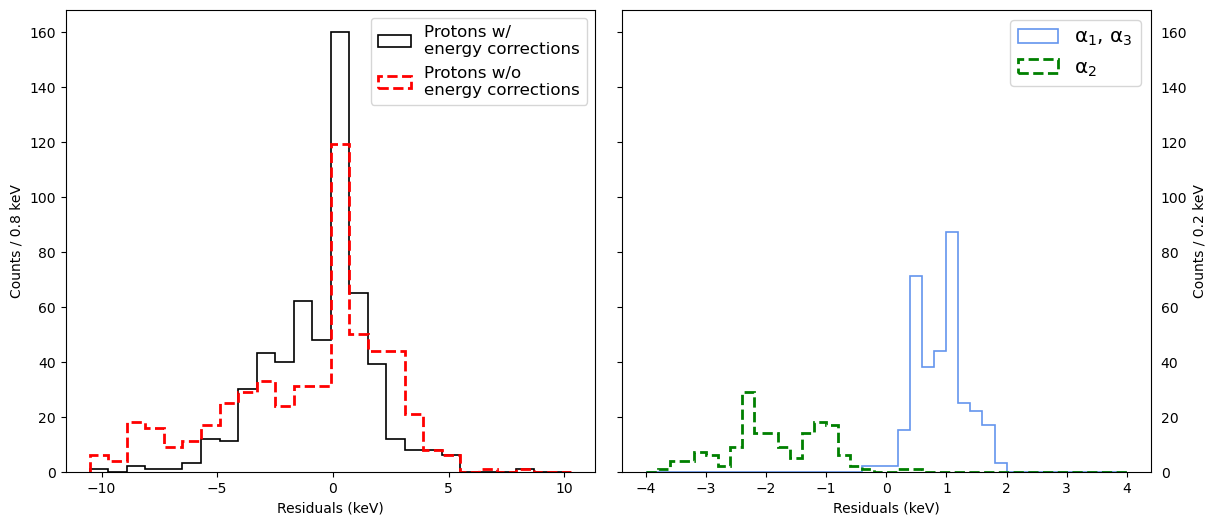

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# The following data and color variables are assumed to be defined elsewhere in your script:
# resp, resp0, resa, wdb, wg

# --- This standard command replaces the custom 'prepare_two_column_figure' function ---
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    sharey=True,
    figsize=(14, 6),  # A reasonable size for a side-by-side layout
    gridspec_kw={'wspace': 0.05}
)

# --- Define binning for histograms ---
bp = np.arange(-10.5, 10.5 + 0.5, 0.8)
ba = np.arange(-4, 4 + 0.1, 0.2)

# --- Populate the Left Plot (axes[0]) ---
ax = axes[0]
ax.hist(resp, bins=bp, histtype='step', color='k', ls='-', lw=1.2, label='Protons w/ \nenergy corrections')
ax.hist(resp0, bins=bp, histtype='step', color='r', ls='--', lw=2, label='Protons w/o \nenergy corrections')
# ax.set_ylim(0.4, 120)
ax.set_xlabel("Residuals (keV)")
ax.set_ylabel("Counts / 0.8 keV")

# === CHANGE 1: Legend position and size fixed ===
# The `bbox_to_anchor` argument is removed to place the legend inside the plot.
# The `fontsize` is increased.
ax.legend(fontsize='large', loc='upper right')
ax.set_zorder(100) # Ensure legend from this plot is drawn on top

# --- Populate the Right Plot (axes[1]) ---
ax = axes[1]
ax.hist(np.array([resa[0::3], resa[2::3]]).flatten(), bins=ba, histtype='step', color='cornflowerblue', ls='-', lw=1.2, label='$\mathrm{\\alpha}_1$, $\mathrm{\\alpha}_3$')
ax.hist(resa[1::3], bins=ba, histtype='step', color='green', ls='--', lw=2, label='$\mathrm{\\alpha}_2$')
ax.set_xlabel("Residuals (keV)")
ax.set_ylabel("Counts / 0.2 keV")
# Move the y-axis ticks and label to the right side
ax.tick_params(labelleft=False, labelright=True)
ax.yaxis.set_label_position("right")
# ax.set_ylim(0.4, 120)

# === CHANGE 2: Legend size fixed ===
ax.legend(fontsize='x-large')

# --- Save and show the final figure ---
plt.savefig("res-distributions.pdf", bbox_inches="tight")
plt.show()

In [81]:
def corr(x, y):
    mx = np.mean(x)
    my = np.mean(y)
    sx = np.std(x, ddof=1)
    sy = np.std(y, ddof=1)
    return np.sum(np.dot(x - mx, y - my))/(len(x) - 1)/sx/sy

In [82]:
print(corr(resp[1::5], resp[0::5]))

-0.9990412896044832


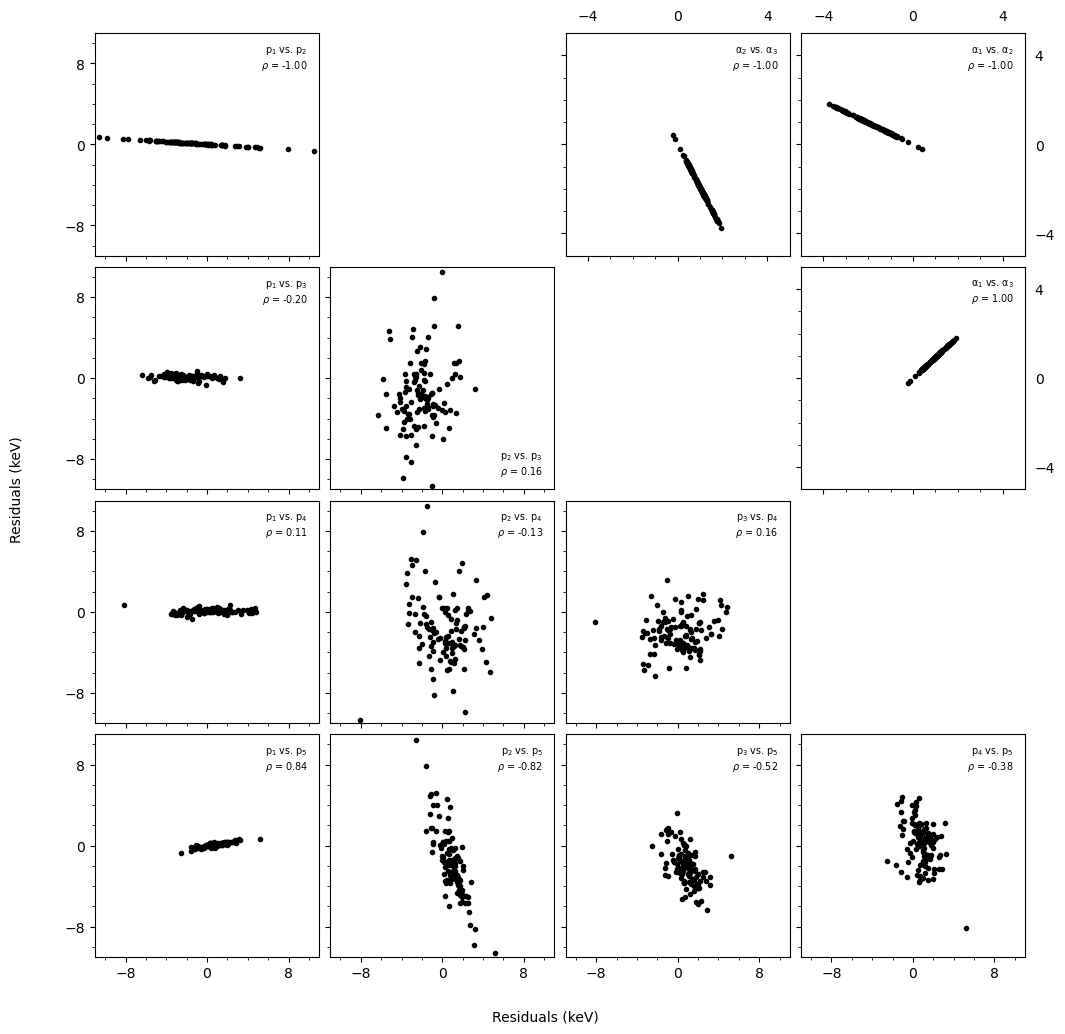

111
164


In [83]:
import matplotlib.pyplot as plt
import numpy as np

# The following variables and functions are assumed to be defined elsewhere in your script:
# resp, resa, corr

# --- Create a single 4x4 figure grid ---
# This standard command replaces the custom 'prepare_two_column_figure' function.
fig, axes = plt.subplots(
    nrows=4,
    ncols=4,
    figsize=(12, 12),  # A square figure size is good for a corner plot
    gridspec_kw={'wspace': 0.05, 'hspace': 0.05}
)

# --- Populate the plot grid ---

# Column 0
axes[0, 0].plot(resp[1::5], resp[0::5], 'k.')
axes[0, 0].text(0.95, 0.95, '$\mathrm{p}_1$ vs. $\mathrm{p}_2$\n$\\rho$ = %1.2f'
                % corr(resp[1::5], resp[0::5]),
                horizontalalignment='right', verticalalignment='top',
                transform=axes[0, 0].transAxes, fontsize='x-small')

axes[1, 0].plot(resp[2::5], resp[0::5], 'k.')
axes[1, 0].text(0.95, 0.95, '$\mathrm{p}_1$ vs. $\mathrm{p}_3$\n$\\rho$ = %1.2f'
                % corr(resp[2::5], resp[0::5]),
                horizontalalignment='right', verticalalignment='top',
                transform=axes[1, 0].transAxes, fontsize='x-small')

axes[2, 0].plot(resp[3::5], resp[0::5], 'k.')
axes[2, 0].text(0.95, 0.95, '$\mathrm{p}_1$ vs. $\mathrm{p}_4$\n$\\rho$ = %1.2f'
                % corr(resp[3::5], resp[0::5]),
                horizontalalignment='right', verticalalignment='top',
                transform=axes[2, 0].transAxes, fontsize='x-small')

axes[3, 0].plot(resp[4::5], resp[0::5], 'k.')
axes[3, 0].text(0.95, 0.95, '$\mathrm{p}_1$ vs. $\mathrm{p}_5$\n$\\rho$ = %1.2f'
                % corr(resp[4::5], resp[0::5]),
                horizontalalignment='right', verticalalignment='top',
                transform=axes[3, 0].transAxes, fontsize='x-small')

# Column 1
axes[1, 1].plot(resp[2::5], resp[1::5], 'k.')
axes[1, 1].text(0.95, 0.05, '$\mathrm{p}_2$ vs. $\mathrm{p}_3$\n$\\rho$ = %1.2f'
                % corr(resp[2::5], resp[1::5]),
                horizontalalignment='right', verticalalignment='bottom',
                transform=axes[1, 1].transAxes, fontsize='x-small')

axes[2, 1].plot(resp[3::5], resp[1::5], 'k.')
axes[2, 1].text(0.95, 0.95, '$\mathrm{p}_2$ vs. $\mathrm{p}_4$\n$\\rho$ = %1.2f'
                % corr(resp[3::5], resp[1::5]),
                horizontalalignment='right', verticalalignment='top',
                transform=axes[2, 1].transAxes, fontsize='x-small')

axes[3, 1].plot(resp[4::5], resp[1::5], 'k.')
axes[3, 1].text(0.95, 0.95, '$\mathrm{p}_2$ vs. $\mathrm{p}_5$\n$\\rho$ = %1.2f'
                % corr(resp[4::5], resp[1::5]),
                horizontalalignment='right', verticalalignment='top',
                transform=axes[3, 1].transAxes, fontsize='x-small')

# Column 2
axes[2, 2].plot(resp[3::5], resp[2::5], 'k.')
axes[2, 2].text(0.95, 0.95, '$\mathrm{p}_3$ vs. $\mathrm{p}_4$\n$\\rho$ = %1.2f'
                % corr(resp[3::5], resp[2::5]),
                horizontalalignment='right', verticalalignment='top',
                transform=axes[2, 2].transAxes, fontsize='x-small')

axes[3, 2].plot(resp[4::5], resp[2::5], 'k.')
axes[3, 2].text(0.95, 0.95, '$\mathrm{p}_3$ vs. $\mathrm{p}_5$\n$\\rho$ = %1.2f'
                % corr(resp[4::5], resp[2::5]),
                horizontalalignment='right', verticalalignment='top',
                transform=axes[3, 2].transAxes, fontsize='x-small')

# Column 3
axes[3, 3].plot(resp[4::5], resp[3::5], 'k.')
axes[3, 3].text(0.95, 0.95, '$\mathrm{p}_4$ vs. $\mathrm{p}_5$\n$\\rho$ = %1.2f'
                % corr(resp[4::5], resp[3::5]),
                horizontalalignment='right', verticalalignment='top',
                transform=axes[3, 3].transAxes, fontsize='x-small')

# --- Populate alpha plots (top-right section) ---
axes[0, 3].plot(resa[1::3], resa[0::3], 'k.')
axes[0, 3].text(0.95, 0.95, '$\mathrm{\\alpha}_1$ vs. $\mathrm{\\alpha}_2$\n$\\rho$ = %1.2f'
                % corr(resa[1::3], resa[0::3]),
                horizontalalignment='right', verticalalignment='top',
                transform=axes[0, 3].transAxes, fontsize='x-small')

axes[1, 3].plot(resa[2::3], resa[0::3], 'k.')
axes[1, 3].text(0.95, 0.95, '$\mathrm{\\alpha}_1$ vs. $\mathrm{\\alpha}_3$\n$\\rho$ = %1.2f'
                % corr(resa[2::3], resa[0::3]),
                horizontalalignment='right', verticalalignment='top',
                transform=axes[1, 3].transAxes, fontsize='x-small')

axes[0, 2].plot(resa[2::3], resa[1::3], 'k.')
axes[0, 2].text(0.95, 0.95, '$\mathrm{\\alpha}_2$ vs. $\mathrm{\\alpha}_3$\n$\\rho$ = %1.2f'
                % corr(resa[2::3], resa[1::3]),
                horizontalalignment='right', verticalalignment='top',
                transform=axes[0, 2].transAxes, fontsize='x-small')

# --- Formatting the grid ---

# Set limits and ticks for proton plots
for ax in [axes[0,0], axes[1,0], axes[2,0], axes[3,0],
           axes[1,1], axes[2,1], axes[3,1],
           axes[2,2], axes[3,2], axes[3,3]]:
    ax.set_xlim(-11, 11)
    ax.set_ylim(-11, 11)
    ax.set_xticks(np.arange(-8, 8 + 8, 8))
    ax.set_xticks(np.arange(-10, 10 + 2, 2), minor=True)
    ax.set_yticks(np.arange(-8, 8 + 8, 8))
    ax.set_yticks(np.arange(-10, 10 + 2, 2), minor=True)

# Set limits and ticks for alpha plots
for ax in [axes[0,2], axes[0,3], axes[1,3]]:
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xticks(np.arange(-4, 4 + 2, 4))
    ax.set_xticks(np.arange(-4, 4 + 1, 1), minor=True)
    ax.set_yticks(np.arange(-4, 4 + 2, 4))
    ax.set_yticks(np.arange(-4, 4 + 1, 1), minor=True)

# Manage tick labels for a clean corner plot look
for i in range(4):
    for j in range(4):
        # Hide all labels by default
        axes[i, j].tick_params(labelbottom=False, labelleft=False)
# Then turn on labels only for the outer plots
for i in range(4):
    axes[i, 0].tick_params(labelleft=True) # Left-most column
for j in range(4):
    axes[3, j].tick_params(labelbottom=True) # Bottom-most row

# Special cases from your script
axes[0, 3].tick_params(labelleft=False, labeltop=True, labelright=True)
axes[1, 3].tick_params(labelright=True)
axes[0, 2].tick_params(labeltop=True)


# Remove unused upper-diagonal subplots
axes[0, 1].remove()
axes[1, 2].remove()
axes[2, 3].remove()

# Add shared, centered axis labels
fig.text(0.06, 0.5, 'Residuals (keV)', rotation='vertical', ha='center', va='center')
fig.text(0.5, 0.06, 'Residuals (keV)', rotation='horizontal', ha='center', va='center')

# --- Save and show the final figure ---
plt.savefig("res-comp-3a-pv.pdf", bbox_inches='tight')
plt.show()

# Print statements from your script
print(len(resp[0::5]))
print(len(resa[0::3]))

In [ ]:
X = np.linspace(0, 3000, 200)
plt.plot(X, lin(X, a1, b1) - lin(X, a2, b2))

In [ ]:
Ep = Ea = np.array([])
for batch in uproot.iterate("../data/deltaEcontained/21mg.root:a", expressions=["E"], 
                            cut="((id == 0) | (id == 1) | (id == 2)) & (1 < FI) & (FI < 16) & (1 < BI) & (BI < 16)"):
    Ep = np.append(Ep, ak.flatten(batch.E))
for batch in uproot.iterate("../data/deltaEcontainedAlpha/21mg.root:a", expressions=["E"], 
                            cut="((id == 0) | (id == 1) | (id == 2)) & (1 < FI) & (FI < 16) & (1 < BI) & (BI < 16)"):
    Ea = np.append(Ea, ak.flatten(batch.E))

In [ ]:
fig = prepare_one_column_figure(height_scale=1.0, fig_scale=2.0)
b = np.arange(0.5, 3.0, 0.004)
#plt.hist(Ep/1e3, bins=b, histtype='step', color='k', ls='-',  lw=1.2, label='Using $^{25}\mathrm{Si}$ proton calibration')
#plt.hist(Ea/1e3, bins=b, histtype='step', color=wb, ls='--', lw=1.0, label='Using triple-α source calibration')
plt.hist(Ep/1e3, bins=b, histtype='step', color='k', ls='-',  lw=1.2, label='Using $^{25}\mathrm{Si}$ p cal.')
plt.hist(Ea/1e3, bins=b, histtype='step', color=wb, ls='--', lw=1.0, label='Using triple-α cal.')
#plt.plot(-100, -100, color='k', ls='-', lw=0.9, label='$^{21}\mathrm{Mg}$ protons from literature')
plt.xlim(0.45, 3.0)
plt.xticks(np.arange(0.5, 3.0+0.1, 0.1), minor=True)
plt.xticks(np.arange(0.5, 3.0+0.5, 0.5))
#plt.yticks(np.arange(0, 4000, 500), minor=True)
plt.ylim(0.6, 2e5)
#plt.ylim(0, 3800)

xs = np.array([1.9383, 1.7730, 1.5019, 1.0590, 0.909, 1.243])
ys = np.array([4.3e3, 2.9e3, 3.7e2, 2.9e2, 3.5e2, 1.3e3])
subs = ["VI", "V", "IV", "II", "I", "III"]
subs_extra = ["", "", "", "", "*", "*"]
#plt.plot(xs, ys, c='r', ls='', marker='v', label='$^{21}\mathrm{Mg}$ protons from literature')
plt.plot(xs, ys, c='r', ls='', marker='v', label='$^{21}\mathrm{Mg}$ p from lit.')
for x, y, sub, sub_e in zip(xs, ys, subs, subs_extra):
    plt.text(x, 1.2*y, "$\mathrm{p_{%s}}%s$" % (sub, sub_e), va='bottom', ha='center', c='r', size='x-small')
#plt.text(1.9383, 4e3)
#plt.text(1.7730, 2.5e3)
#plt.text(1.5019, 3.5e2)

plt.yscale('log')

#b2 = np.arange(1.65, 2.1, 0.004)
#axin = plt.gca().inset_axes([1.05, 0.4, 0.50, 0.30])
#axin.hist(Ep/1e3, bins=b2, histtype='step', color=wb, ls='-',  lw=1.2)
#axin.hist(Ea/1e3, bins=b2, histtype='step', color='r', ls='--', lw=1.0)
#axin.vlines([1.9383, 1.7730], 0, [3800, 2500], color='k', ls='-', lw=0.9)
#axin.tick_params(labelleft=False, labelright=True, labelsize='xx-small')
#axin.set_xticks(np.arange(1.7, 2.1, 0.2))
#axin.set_xticks(np.arange(1.65, 2.1+0.05, 0.05), minor=True)
#axin.set_yticks(np.arange(0, 4000, 2000))
#axin.set_yticks(np.arange(0, 4000, 500), minor=True)
#axin.get_yaxis().set_visible(False)
#axin.get_xaxis().set_visible(False)

#fig.gca().indicate_inset_zoom(axin, edgecolor="black")
plt.xlabel("$E_{\mathrm{p}}$ (MeV)")
plt.ylabel("Counts / 4 keV")
#plt.legend(fontsize='xx-small', bbox_to_anchor=(1., 1.))
plt.legend(fontsize='xx-small', loc='upper left', ncol=2)
plt.savefig('padVetoedCalComp.pdf', bbox_inches='tight')
plt.show()

In [ ]:
from scipy.optimize import curve_fit
def gaus(x, mu, sigma, A):
    return A*np.exp(-0.5*(x-mu)**2/sigma**2)/sigma/np.sqrt(2*np.pi)

In [ ]:
X1 = np.linspace(1.73, 1.82, 100)
data1 = plt.hist(Ep/1e3, bins=b)
y1 = data1[0]
x1 = data1[1]
x1 = x1[0:-1] + (x1[1] - x1[0])/2
plt.xlim(1.73, 1.82)
f1 = (1.73 <= x1) & (x1 <= 1.82)
p1, pc1 = curve_fit(gaus, x1[f1], y1[f1], p0=(1.78, 5, 2000), sigma=np.sqrt(y1[f1]), absolute_sigma=True)
plt.plot(X1, gaus(X1, *p1))
plt.show()

X2 = np.linspace(1.7, 1.81, 100)
data2 = plt.hist(Ea/1e3, bins=b)
y2 = data2[0]
x2 = data2[1]
x2 = x2[0:-1] + (x2[1] - x2[0])/2
plt.xlim(1.7, 1.81)
f2 = (1.7 <= x2) & (x2 <= 1.81)
p2, pc2 = curve_fit(gaus, x2[f2], y2[f2], p0=(1.75, 5, 2000), sigma=np.sqrt(y2[f2]), absolute_sigma=True)
plt.plot(X2, gaus(X2, *p2))
plt.show()

print(p1[1], p2[1])
print(2*np.sqrt(2*np.log(2))*p1[1], 2*np.sqrt(2*np.log(2))*p2[1])
print("FWHM from 50 keV down to 42 keV on this particular peak")
print("relative improvement of", 100*(50 - 42)/50, "%")

In [ ]:
X3 = np.linspace(1.88, 1.99, 100)
plt.hist(Ep/1e3, bins=b)
plt.xlim(1.88, 1.99)
f3 = (1.88 <= x1) & (x1 <= 1.99)
p3, pc3 = curve_fit(gaus, x1[f3], y1[f3], p0=(1.93, 5, 2000), sigma=np.sqrt(y1[f3]), absolute_sigma=True)
plt.plot(X3, gaus(X3, *p3))
plt.show()

X4 = np.linspace(1.86, 1.97, 100)
plt.hist(Ea/1e3, bins=b)
plt.xlim(1.86, 1.97)
f4 = (1.86 <= x2) & (x2 <= 1.97)
p4, pc4 = curve_fit(gaus, x2[f4], y2[f4], p0=(1.90, 5, 2000), sigma=np.sqrt(y2[f4]), absolute_sigma=True)
plt.plot(X4, gaus(X4, *p4))
plt.show()

print(p3[1], p3[1])
print(2*np.sqrt(2*np.log(2))*p3[1], 2*np.sqrt(2*np.log(2))*p4[1])
print("FWHM from 60 keV down to 55 keV on this particular peak")
print("relative improvement of", 100*(60 - 55)/60, "%")

In [ ]:
ap = bp = aa = ba = np.array([])
prefixes = ["U1.cal", "U2.cal", "U3.cal", "U4.cal"]
# prefixes = ["U2.cal"]
for pref in prefixes:
    b, a = np.loadtxt("../setup/%s" % pref, unpack=True)
    ap = np.append(ap, a)
    bp = np.append(bp, b)
    b, a = np.loadtxt("../setup/%s.alpha" % pref, unpack=True)
    aa = np.append(aa, a)
    ba = np.append(ba, b)

In [ ]:
def lin(x, a, b):
    return a*x + b

In [ ]:
fig = prepare_two_column_figure(height_scale=0.6, fig_scale=2.0)

i = 1
for a0, b0, a1, b1 in zip(aa, ba, ap, bp):
    if a1 == 0 or a0 == 0:
        i +=1
        continue
    plt.plot([i, i], [lin(   0, a1, b1) - lin(   0, a0, b0),
                      lin(1900, a1, b1) - lin(1900, a0, b0)], 'k.-')
    plt.plot(i, lin(1900, a1, b1) - lin(1900, a0, b0), marker='s', color='r', ms=4)
    i += 1

texts = ["U1p", "U1n", "U2p", "U2n", "U3p", "U3n", "U4p", "U4n"]
xt    = [9, 25, 41, 57, 73, 89, 105, 121]
yt    = [-50, -50, -50, 100, 100, 100, -50, 100]
for text, x, y in zip(texts, xt, yt):
    plt.text(x, y, text, ha='center', va='center')
plt.xlabel('Channel number')
plt.ylabel('$\Delta E_{\mathrm{dep}}(x)$ (keV)')
plt.xlim(0.1, 130)
plt.plot(-10, 0, 'k.', label='$x=0$')
plt.plot(-10, 0, marker='s', linestyle='', color='r', ms=4, label='$x=1900$')
plt.text(37.7+0.3, 55, '→', rotation=-90.)
plt.text(40, 85, 'Strip of\nfigure 7.5', ha='center', fontsize='xx-small')
plt.text(101.7+0.3, 99, '→', rotation=-90.)
plt.text(103, 125, 'Strip of\nfigure 7.11', ha='left', fontsize='xx-small')
plt.legend()
plt.savefig('Edep-diff.pdf', bbox_inches='tight')
plt.show()

In [91]:
base = "U5F7"
with uproot.open("../../data/cal/3aha_before.root") as file:
    # data
    y1a_, x1a_ = file[base].to_numpy()
    x0a_ = np.min(x1a_)
    x1a_ = x1a_[:-1] + 0.5
    # tspectrum
    y2a_, x2a_ = file[base + "A"].to_numpy()
    x2a_ = x2a_[:-1] + 0.5 + x0a_
    # peak positions, in found order
    x3a_, y3a_ = file[base + "P"].values()
    x3a_ = x3a_ + x0a_
for i in range(len(x1a_)):
    xtmp = x1a_[i]
    if 1350 <= xtmp and xtmp <= 1380:
        y1a_[i] = 2 + np.random.uniform(-2, 2)
    if 1450 <= xtmp and xtmp <= 1475:
        y1a_[i] = 2 + np.random.uniform(-2, 2)
with uproot.open("../../data/cal/pha.root") as file:
    # data
    y1p_, x1p_ = file[base].to_numpy()
    x0p_ = np.min(x1p_)
    x1p_ = x1p_[:-1] + 0.5
    # tspectrum
    y2p_, x2p_ = file[base + "A"].to_numpy()
    x2p_ = x2p_[:-1] + 0.5 + x0p_
    # peak positions, in found order
    x3p_, y3p_ = file[base + "P"].values()
    x3p_ = x3p_ + x0p_

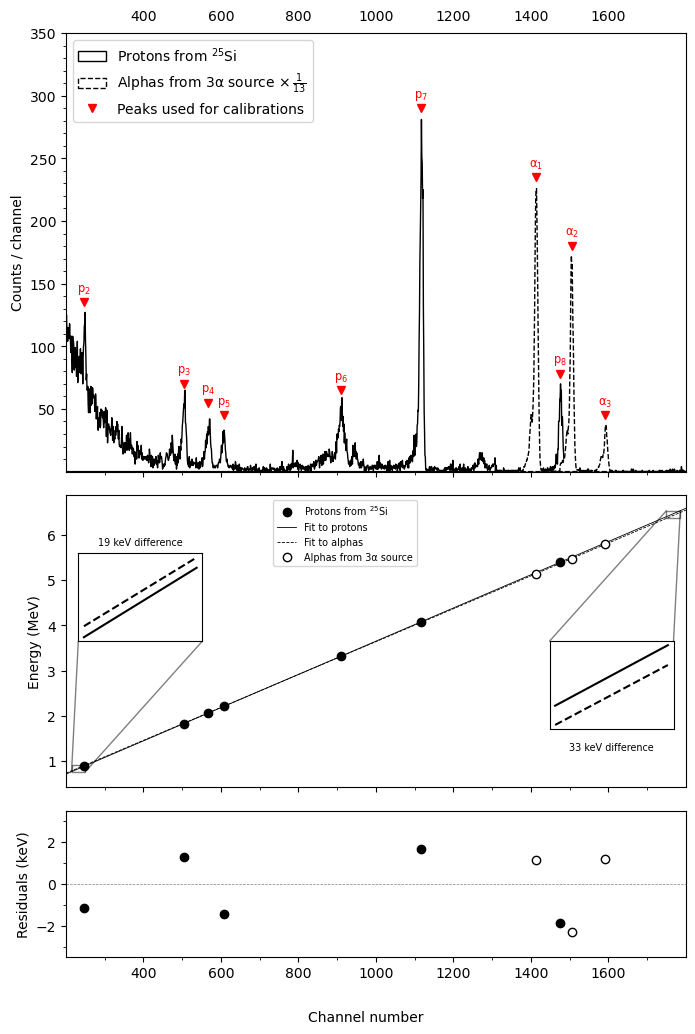

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# --- Definitions from your script ---
# These are preserved exactly as you provided them.
xl1_ = 200
xu1_ = 1800
xl2_ = 1350
xu2_ = 1650

def lin(x, a, b):
    return a*x + b
def lin_err(x, aerr, berr, aberr):
    return np.sqrt(aerr*x**2* + berr + x*aberr)
# U5F7 alpha 6.827784370976031 3.6347515137514383
# U5F7 alpha [ 1.13010269 -2.32512651  1.19502382]
#U5F7 p -19.90772265800977 3.6715577680429927
# [-1.17159999  1.30635843  4.25521774 -1.45560435  8.98940385  1.67941548 -1.88692107]
XP_ = np.linspace(xl1_, xu1_, 100)
aa_prot = 3.6715577680429927
bb_prot = -19.90772265800977
aa_alph = 3.6347515137514383
bb_alph = 6.827784370976031

# The following data variables are assumed to be defined elsewhere in your script:
# x1p_, y1p_, x1a_, y1a_, x3p_, y3p_, x3a_

# --- Create a single 3x1 figure grid ---
# This standard command replaces the custom 'prepare_two_column_figure' function.
fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    sharex=True,
    figsize=(8, 12),  # A reasonable size for a 3x1 vertical layout
    gridspec_kw={'hspace': 0.08, 'height_ratios': [3, 2, 1]}
)

# --- Populate the Top Plot (axes[0]) ---
ax = axes[0]
xpl = np.min(x1p_)
xpu = np.max(x1p_)

ax.fill_between(x1p_, 0, y1p_, edgecolor='k', facecolor='w', label='Protons from $^{25}\mathrm{Si}$')
ax.fill_between(x1a_[x1a_ > xl2_ + 5], 0, y1a_[x1a_ > xl2_ + 5]/13, edgecolor='k', facecolor='w', linestyle='--',
                label='Alphas from 3α source $\\times\,\\frac{1}{13}$')

ax.set_yticks(np.arange(50, 350 + 50, 50))
ax.set_yticks(np.arange(10, 350 + 10, 10), minor=True)
ax.set_ylim(0, 350)
ax.tick_params(labeltop=True) # `sharex=True` handles labelbottom=False automatically
ax.set_ylabel("Counts / channel")

x4p_ = np.array([247.00124033,  504.00714932,  566.99979585,  606.99394312,  910.00292788, 1117.00497889, 1476.0014648 ])
y4p_ = np.array([135, 70, 55, 45, 65, 290, 78])
ax.plot(x4p_, y4p_, c='r', ls='', marker='v', label='Peaks used for calibrations')
subs = ["2", "3", "4", "5", "6", "7", "8"]
for x, y, sub in zip(x4p_, y4p_, subs):
    ax.text(x, y+5, "$\mathrm{p_{%s}}$" % sub, va='bottom', ha='center', c='r', size='small')
y3a_ = [235, 180, 45]
ax.plot(x3a_[0:3], y3a_, c='r', ls='', marker='v')
subs = ["1", "2", "3"]
for x, y, sub in zip(x3a_[0:3], y3a_, subs):
    ax.text(x, y+5, "$\mathrm{\\alpha_{%s}}$" % sub, va='bottom', ha='center', c='r', size='small')

ax.legend(loc='upper left')

# --- Populate the Middle Plot (axes[1]) ---
ax = axes[1]
ax.plot(x4p_, lin(x4p_, aa_prot, bb_prot)/1e3, 'ko', label='Protons from $^{25}\mathrm{Si}$')
ax.plot(XP_, lin(XP_, aa_prot, bb_prot)/1e3, 'k-', lw=0.6, label='Fit to protons')
ax.plot(XP_, lin(XP_, aa_alph, bb_alph)/1e3, 'k--', lw=0.6, label='Fit to alphas')
ax.plot(x3a_[0:3], lin(x3a_[0:3], aa_alph, bb_alph)/1e3, 'ko', markerfacecolor='w', zorder=10,
        label='Alphas from 3α source')

axin1 = ax.inset_axes([0.02, 0.5, 0.20, 0.30])
f1_ = (200 < XP_) & (XP_ < 250)
axin1.plot(XP_[f1_], lin(XP_[f1_], aa_prot, bb_prot)/1e3, 'k-')
axin1.plot(XP_[f1_], lin(XP_[f1_], aa_alph, bb_alph)/1e3, 'k--')
axin1.set_xticks([])
axin1.set_yticks([])
ax.indicate_inset_zoom(axin1, edgecolor="black")
axin1.set_title(f"{int(abs(lin(xl1_,aa_prot,bb_prot)-lin(xl1_,aa_alph,bb_alph)))} keV difference", fontsize='x-small')

axin2 = ax.inset_axes([0.98-0.20, 0.2, 0.20, 0.30])
f2_ = (1750 < XP_) & (XP_ < 1800)
axin2.plot(XP_[f2_], lin(XP_[f2_], aa_prot, bb_prot)/1e3, 'k-')
axin2.plot(XP_[f2_], lin(XP_[f2_], aa_alph, bb_alph)/1e3, 'k--')
axin2.set_xticks([])
axin2.set_yticks([])
ax.indicate_inset_zoom(axin2, edgecolor="black")
axin2.set_title(f"{int(abs(lin(xu2_,aa_prot,bb_prot)-lin(xu2_,aa_alph,bb_alph)))} keV difference", y=-0.34, fontsize='x-small')

ax.set_yticks(np.arange(1, 6, 1), minor=True)
ax.legend(fontsize='x-small', loc='upper center', bbox_to_anchor=(0.45, 1))
ax.set_ylabel("Energy (MeV)")

# --- Populate the Bottom Plot (axes[2]) ---
ax = axes[2]
ax.plot([xl1_, xu1_], [0, 0], ls='--', c='grey', lw=0.5)
ax.plot(x4p_, [-1.17159999,  1.30635843,  4.25521774, -1.45560435,  8.98940385,  1.67941548, -1.88692107], 'ko')
ax.plot(x3a_[0:3], [ 1.13010269, -2.32512651,  1.19502382], 'ko', markerfacecolor='w')
ax.set_ylabel("Residuals (keV)")
ax.set_ylim(-3.5, 3.5)
ax.set_yticks(np.arange(-2, 2 + 2, 2))
ax.set_yticks(np.arange(-3, 3 + 1, 1), minor=True)

ax.set_xlim(xl1_, xu1_)
ax.set_xticks(np.arange(400, 1800, 200))
ax.set_xticks(np.arange(300, 1800, 100), minor=True)

# --- Final Figure-level Formatting ---
fig.text(0.5, 0.06, 'Channel number', rotation='horizontal', ha='center', va='center')
plt.savefig("U5F7siacomp.pdf", bbox_inches='tight')
plt.show()

In [ ]:
base = "P3"
with uproot.open("../../data/cal/3aha.root") as file:
    # data
    y1a, x1a = file[base].to_numpy()
    x0a = np.min(x1a)
    x1a = x1a[:-1] + 0.5
    # tspectrum
    y2a, x2a = file[base + "A"].to_numpy()
    x2a = x2a[:-1] + 0.5 + x0a
    # peak positions, in found order
    x3a, y3a = file[base + "P"].values()
    x3a = x3a + x0a
with uproot.open("../../data/cal/pvha.root") as file:
    # data
    y1p, x1p = file[base].to_numpy()
    x0p = np.min(x1p)
    x1p = x1p[:-1] + 0.5
    # tspectrum
    y2p, x2p = file[base + "A"].to_numpy()
    x2p = x2p[:-1] + 0.5 + x0p
    # peak positions, in found order
    x3p, y3p = file[base + "P"].values()
    x3p = x3p + x0p

from scipy.optimize import curve_fit
def lin(x, a, b):
    return a*x + b